<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/SIR_stabilityanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r [S+Rs+(1-\epsilon_L) Rp] - \gamma_r I_r $

$\frac{\mathrm{d}R_s}{\mathrm{d}t} = (1-\epsilon_a)\gamma_rI_r - (\beta_r I_r) Rs $

$\frac{\mathrm{d}R_p}{\mathrm{d}t} = \epsilon_a\gamma_rI_r - \beta_r I_r(1-\epsilon_L) Rp$


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
# SIR model equations
def SIR_model(t, y, mu, beta, gamma, epsilonL):
    S, I, R, CI  = y


    dSdt = -(beta * I * S)
    dIdt = beta * I * (S + (1-epsilonL)*R)  - gamma * I

    dRdt =  gamma * I - beta*I*(1-epsilonL)*R

    #will include indImiduals that get reinfected as multiple infections
    #cumulative infections
    dCIdt = beta * I * (S + (1-epsilonL)*R)


    return [dSdt, dIdt, dRdt, dCIdt]



#basic plot to show comaprtment prevalence across time
def plot_basic(solution, figsize = (8,5)):
  t = solution.t
  S, I, R, CI  = solution.y

  plt.figure(figsize=figsize)
  plt.plot(t, S, label='Susceptible')
  plt.plot(t, I, label='Infected')
  plt.plot(t, R, label='Recovered w Immunity_leaky')


  plt.xlabel('Time (days)')
  plt.ylabel('Proportion of Population')
  plt.title('SIR Model Simulation with Variant')
  plt.legend()
  plt.grid(True)
  plt.show




#find final cumulative infections
def find_finalCI(solution):
  S, I, R, CI  = solution.y
  t = solution.t
  return(CI[-1])

#find whether it is a one wave epidemic or endemic equil
def I_wave_or_end(solution):
  S, I, R, CI  = solution.y

  if I[-1] > 0.02: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"

def find_I_peak(solution, wave_or_end: str):
  S, I, R, CI  = solution.y

  if wave_or_end == "wave":
    return max(I)

  else:
    return pd.NA

def find_I_equil(solution, wave_or_end: str):
  S, I, R, CI  = solution.y

  if wave_or_end == "endemic":
    return I[-1]

  else:
    return pd.NA

#function for plotting infected for many epsilons. two means 2 subplots
def plot_many_eps(figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with epsilon_a as as keys, values being a list of epsilon_l and solution

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)

  for epsL_key, eps_solut in kwargs.items():
    S, I, R, CI = eps_solut.y #takes solution (index 1) out from list
    t = eps_solut.t

    label = "epsilon_L = " + epsL_key
    ax1.plot(t, I, label=label, alpha=0.5)


  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel('Prevalence of resident')
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

/tmp/ipython-input-3118970494.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one_strain_df.loc[len(one_strain_df)] = [
/tmp/ipython-input-3118970494.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one_strain_df.loc[len(one_strain_df)] = [
/tmp/ipython-input-3118970494.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To re

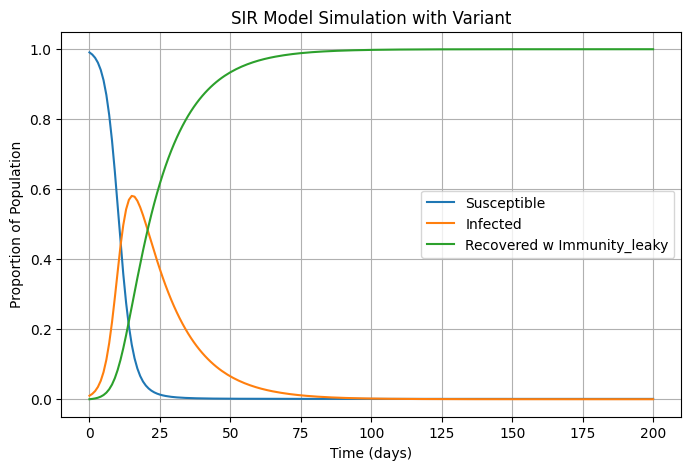

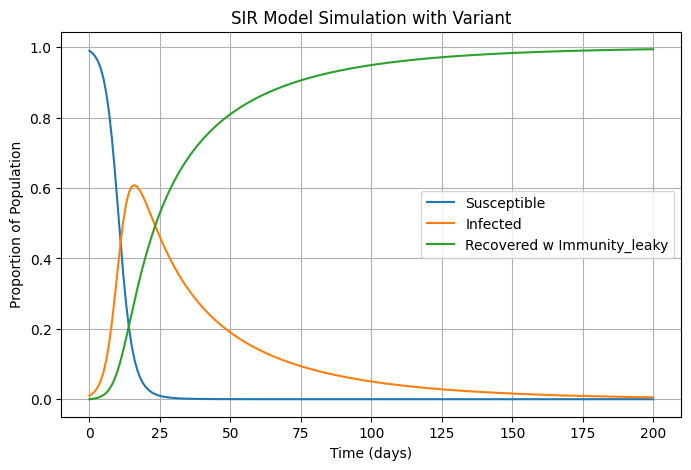

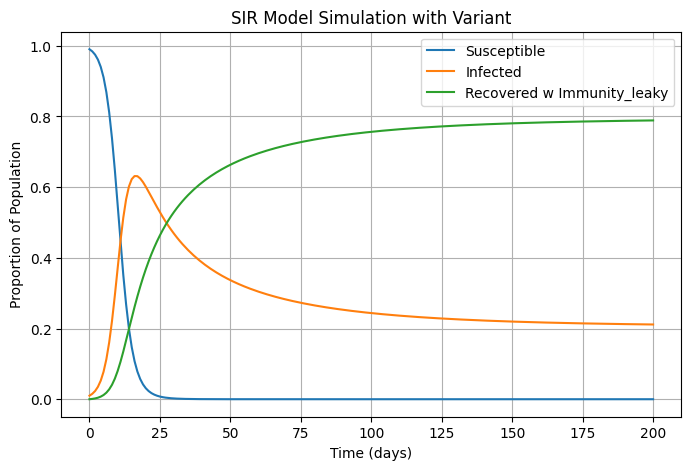

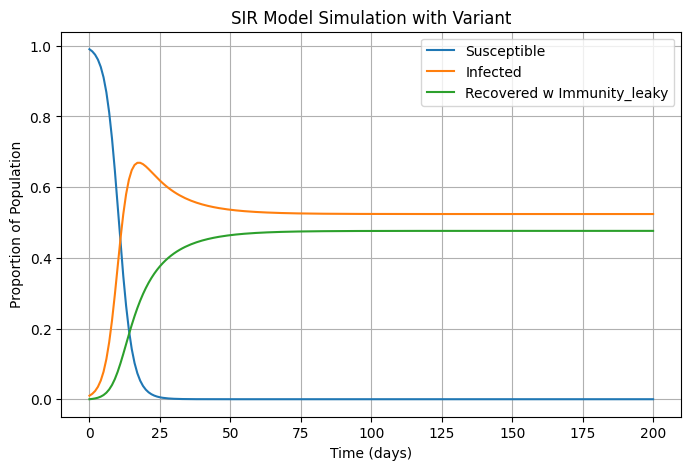

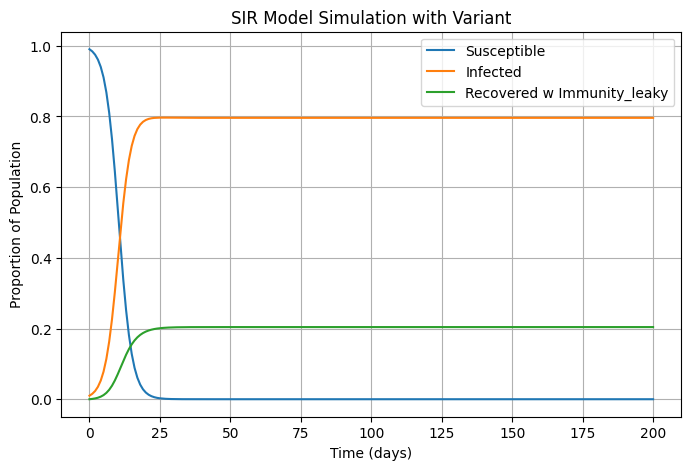

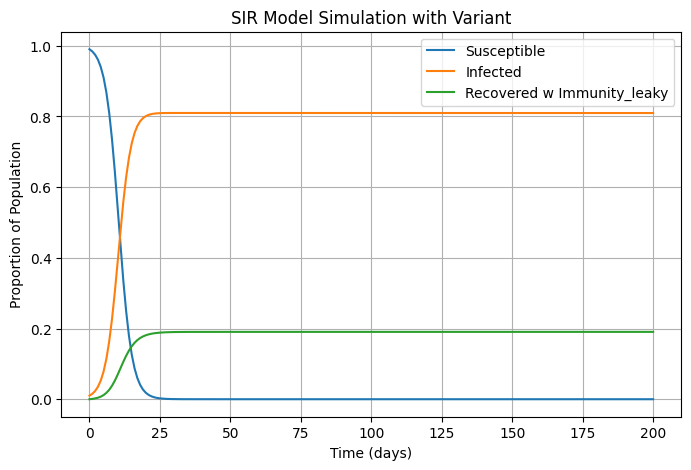

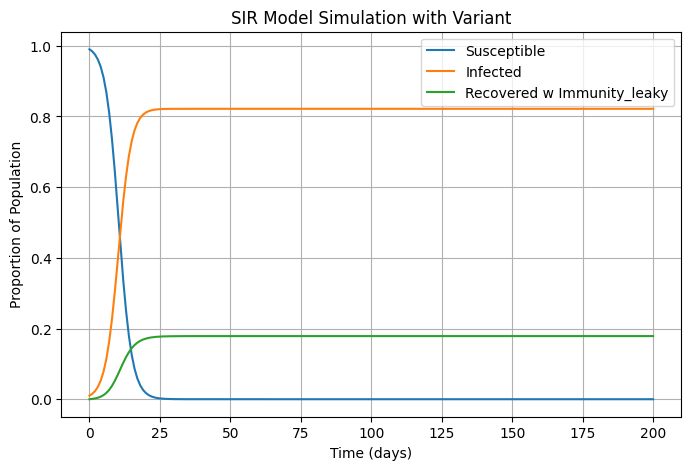

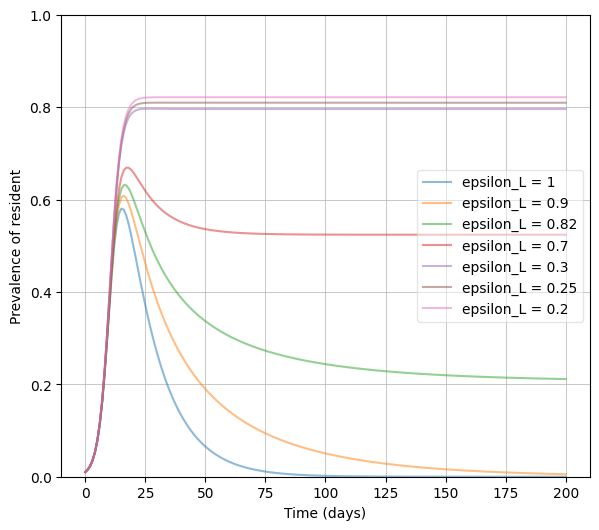

In [33]:
one_strain_df = pd.DataFrame(columns=['epsilon_L', 'mu', 'CI', 'one-wave or endemic', "peak I", 'equil_I'])
##immunity overall = 0.25
Rnaught = 1.6
gamma = 1/14
beta = 1/2 #gamma*Rnaught
#Rwnaught = betaw / gammaw # R0 for residents with entirely susceptible population

# set initial conditions
S0 = 0.99
R0 = 0.0

I0 = 1-(S0+Rs0+Rp0)
CI0 = I0
y0 = [S0, I0, R0, CI0]


epsilonL_vals = [1, 0.9, 0.82, 0.7, 0.3, 0.25, 0.2]
kwargs = {}
solutions = []
mu = 0.6
t = 200

#loop thru epsilon values and solve to get many solutions at same protection level
for i in range(len(epsilona_vals)):
  epsilona = epsilona_vals[i]
  epsilonL = epsilonL_vals[i]
  solution = solve_ivp(SIR_model,
                      [0,t],
                      y0,
                      args=(mu, beta, gamma, epsilonL_vals[i]),
                      dense_output=True,
                      t_eval=np.linspace(0, t, t + 1),)
  solutions.append(solution)
  kwargs[str(epsilonL_vals[i])] = solutions[i]
  plot_basic(solution)


  #add to df
  one_strain_df.loc[len(one_strain_df)] = [
                                epsilonL,
                                mu,
                                find_finalCI(solution),
                                I_wave_or_end(solution),
                                find_I_peak(solution, I_wave_or_end(solution)),
                                find_I_equil(solution, I_wave_or_end(solution))]

plot_many_eps(ylim_max = 1,**kwargs)

EQUILIBRIUM ANALYSIS

In [5]:
import sympy as sp

S, I, R, beta, gamma, epsilonL = sp.symbols('S I r beta gamma epsilonL', positive=True)

dS = -(beta * I * S)
dI = beta * I * (S + (1-epsilonL)*R)  - gamma * I
dRdt = gamma * I - beta*I*(1-epsilonL)*R

equilibria = sp.solve([dI], R)
equilibria


{r: (S*beta - gamma)/(beta*epsilonL - beta)}